In [50]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
# import datetime as dt
from datetime import datetime, timedelta
import calendar

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat


import cmocean

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC
from LIB_PPdrift_NSIDC0116 import grab_ice_Drift, grab_icedrift_range

## Grab sea ice motion coordinates

In [36]:

(u, xx_d, yy_d, lon, lat, drift_proj) = grab_ice_Drift(date=datetime(2000,1,1), return_vars=['u','xx', 'yy', 'lon', 'lat', 'proj'], 
                                          lat_range=[0, 90], lon_range=[0, 360])

coords = {}
coords['sim'] = {}

coords['sim']['xx'] = xx_d
coords['sim']['yy'] = yy_d
coords['sim']['proj'] = drift_proj
coords['sim']['lat'] = lat
coords['sim']['lon'] = lon
coords['sim']['mask'] = np.isnan(u)
            

### Import MASIE regions

In [37]:


ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/MASIE/masiemask_ims4km.nc')
ds.close()

CRS = ds.polar_stereographic.attrs
MASIE_proj = ccrs.Stereographic(central_latitude=CRS['latitude_of_projection_origin'], 
                                central_longitude=CRS['straight_vertical_longitude_from_pole'], 
                             false_easting=CRS['false_easting'],
                             false_northing=CRS['false_northing'],
                             true_scale_latitude=CRS['standard_parallel'])

# save to dictionary
coords['MASIE'] = {}
coords['MASIE']['xx'] = ds.x.values
coords['MASIE']['yy'] = ds.y.values
coords['MASIE']['proj'] = MASIE_proj
coords['MASIE']['lat'] = ds.lat.values
coords['MASIE']['lon'] = ds.lon.values
coords['MASIE']['area'] = ds.area.values

# don't need to define globe since WGS84 ellipsoid is the cartopy default
ds

<xarray.Dataset>
Dimensions:              (x: 6144, y: 6144)
Coordinates:
  * x                    (x) float64 -1.229e+07 -1.228e+07 ... 1.229e+07
  * y                    (y) float64 1.229e+07 1.228e+07 ... -1.229e+07
Data variables:
    mask                 (y, x) float32 ...
    polar_stereographic  int32 ...
    regions              (y, x) int8 ...
    lat                  (y, x) float32 -21.48 -21.48 -21.47 ... -21.48 -21.48
    lon                  (y, x) float32 145.0 145.0 145.0 ... -35.01 -35.0
    area                 (y, x) float32 1.869 1.869 1.87 ... 1.87 1.869 1.869
Attributes:
    Conventions:    CF-1.4
    institution:    National Snow and Ice Data Center, Boulder, CO
    contact:        For assistance with this data, please contact the NSIDC U...
    creation_time:  Wed Sep 23 07:12:35 2015
    created_by:     vagrant

In [10]:

file = '/Volumes/Seagate_Jewell/KenzieStuff/MASIE/MASIE_regions_polygon_vertices.xlsx'

df = pd.read_excel(file, header=1, index_col=0)

rgn_bnds = {}
for rr in df.index.values:
    
    rgn_bnds[rr] = {}
    rgn_bnds[rr]['name'] = df.loc[rr][0]

    # grab coordinates
    coordinates = df.loc[rr][1:].values.astype(float)
    lats = coordinates[np.arange(0, len(coordinates), 2)]
    lons = coordinates[np.arange(1, len(coordinates), 2)]

    # remove nans
    rgn_bnds[rr]['lat'] = lats[np.isfinite(lats)]
    rgn_bnds[rr]['lon'] = lons[np.isfinite(lons)]
    
    
    out = coords['MASIE']['proj'].transform_points(ccrs.PlateCarree(), rgn_bnds[rr]['lon'], rgn_bnds[rr]['lat'])
    rgn_bnds[rr]['xx'] = out[:,0]
    rgn_bnds[rr]['yy'] = out[:,1]
    
    # repeat last point
    for coord in ['xx', 'yy', 'lat', 'lon']:
        rgn_bnds[rr][coord] = np.append(rgn_bnds[rr][coord], rgn_bnds[rr][coord][0])

### Convert MASIE corner coordinates to SIM projection

In [ ]:
out = coords['sim']['proj'].transform_points(coords['MASIE']['proj'], rgn_bnds[1]['xx'], rgn_bnds[1]['yy'])
BF_xx = out[:,0]
BF_yy = out[:,1]

### Find SIM points within Beaufort Sea

In [ ]:
from shapely.geometry import Polygon, Point

coordinates = list(zip(BF_xx, BF_yy))
poly = Polygon(coordinates)

# polygon = Polygon(coords)

within_poly = np.full(coords['sim']['xx'].shape, False)


for ii in range(np.shape(within_poly)[0]):
    for jj in range(np.shape(within_poly)[1]):
        
        if poly.contains(Point(coords['sim']['xx'][ii, jj], coords['sim']['yy'][ii, jj])):
            
            within_poly[ii, jj] = True

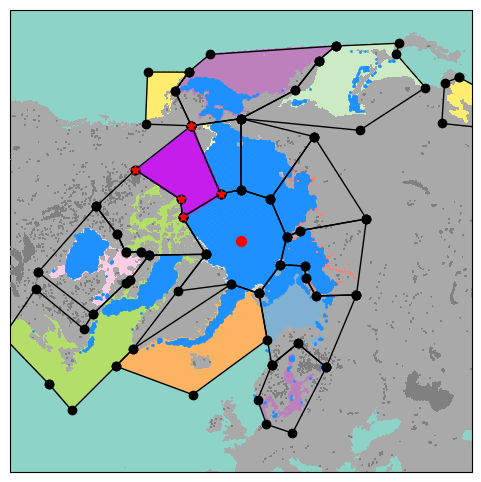

In [47]:


%matplotlib inline


fig, ax = plt.subplots(figsize=(6,6), subplot_kw = {'projection': coords['sim']['proj']})
ax.set_ylim(-5000000,5000000)
ax.set_xlim(-5000000,5000000)


sp = 5
ax.pcolormesh(ds.x[::sp], ds.y[::sp], ds.regions[::sp,::sp], cmap='Set3', zorder=1, transform = coords['MASIE']['proj'])
ax.pcolormesh(ds.x[::sp], ds.y[::sp], ds.mask[::sp,::sp]==2, cmap=matplotlib.colors.ListedColormap(['None', 'darkgray']),transform = coords['MASIE']['proj'], zorder=2)
ax.pcolormesh(ds.x[::sp], ds.y[::sp], ds.mask[::sp,::sp]==5, cmap=matplotlib.colors.ListedColormap(['None', 'gray']),transform = coords['MASIE']['proj'], zorder=3)

for rr in rgn_bnds.keys():
    ax.plot(rgn_bnds[rr]['xx'], rgn_bnds[rr]['yy'], c='k', marker='o', lw=1, transform=coords['MASIE']['proj'], zorder=5)

ax.scatter(coords['sim']['xx'][coords['sim']['mask']==False], 
           coords['sim']['yy'][coords['sim']['mask']==False], 
           transform = coords['sim']['proj'], c='dodgerblue', s=1, zorder=4)

ax.scatter(0,90, c='r', s=50, transform=ccrs.PlateCarree(), zorder=100)


ax.scatter(BF_xx, BF_yy, marker='*',c='r', transform=coords['sim']['proj'], zorder=1000)
ax.add_geometries([poly], alpha=0.25, crs = coords['sim']['proj'], zorder=999)


ax.scatter(coords['sim']['xx'][within_poly], 
           coords['sim']['yy'][within_poly], 
           transform = coords['sim']['proj'], c='magenta', s=1, zorder=4)


In [45]:
(u, xx_d, yy_d, lon, lat, drift_proj) = grab_ice_Drift(date=datetime(2000,1,1), 
                                                       return_vars=['u','xx', 'yy', 'lon', 'lat', 'proj'], 
                                          lat_range=[0, 90], lon_range=[0, 360])


In [112]:
all_u = np.array([])
all_v = np.array([])
all_s = np.array([])
all_nanfrac = np.array([])

years = np.arange(1978, 2023)

for year in years:

    [u, v] = grab_icedrift_range(start_date=datetime(year, 1, 1), 
                        end_date=datetime(year, 12, 31), 
                        PPD_drift_path='/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
                        PPD_filename='icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                        return_vars=['u', 'v'],lat_range=[0, 90], lon_range=[0, 360])
    # ice drift speed
    s = np.sqrt(u**2 + v**2)
    
    # find daily means
    avg_u = np.array([])
    avg_v = np.array([])
    avg_s = np.array([])
    nan_frac = np.array([])
    
    for tt in range(len(u)): 
        avg_u = np.append(avg_u, np.nanmean(u[tt][within_poly]))
        avg_v = np.append(avg_v, np.nanmean(v[tt][within_poly]))
        avg_s = np.append(avg_s, np.nanmean(s[tt][within_poly]))
        
        nans = np.sum(np.isnan(s[tt][within_poly]))
        total = len(s[tt][within_poly])
        nan_frac = np.append(nan_frac, nans/total)

    # save to master list
    all_u = np.append(all_u, avg_u[:365])
    all_v = np.append(all_v, avg_v[:365])
    all_s = np.append(all_s, avg_s[:365])
    all_nanfrac = np.append(all_nanfrac, nan_frac[:365])

/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_90008/582593167.py:25: RuntimeWarning: Mean of empty slice
  avg_u = np.append(avg_u, np.nanmean(u[tt][within_poly]))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_90008/582593167.py:26: RuntimeWarning: Mean of empty slice
  avg_v = np.append(avg_v, np.nanmean(v[tt][within_poly]))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_90008/582593167.py:27: RuntimeWarning: Mean of empty slice
  avg_s = np.append(avg_s, np.nanmean(s[tt][within_poly]))
/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/..

/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()
/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()
/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standar

/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()
/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()
/Users/mackenziejewell/Documents/GitHub/PrettyPolarPlots/../Libraries_functions/LIB_PPdrift_NSIDC0116.py:411: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standar

In [113]:
all_u = np.reshape(all_u, (len(years), int(len(all_u)/len(years))))
all_v = np.reshape(all_v, (len(years), int(len(all_v)/len(years))))
all_s = np.reshape(all_s, (len(years), int(len(all_s)/len(years))))
all_nanfrac = np.reshape(all_nanfrac, (len(years), int(len(all_nanfrac)/len(years))))

In [117]:

ds_ice =xr.Dataset(
            data_vars=dict(
                u=(["year", "doy"], all_u, {"units": "cm/s", "long_name":"average eastward"}),
                v=(["year", "doy"], all_v, {"units": "cm/s", "long_name":"average northward"}),
                speed=(["year", "doy"], all_s, {"units": "cm/s", "long_name":"average speed"}),
                nan_frac = (["year", "doy"], all_nanfrac, {"units": " ", "long_name":"fraction of region that are nan"}), 

            ),
            coords=dict(
                year =(["year"], years),
                doy=(["doy"], np.arange(1,366), {"units": "day", "long_name":"julian from Jan 1 (doy=1)"}),
               # time=date_list,
            ),
            attrs=dict(description="Ice drift averages in MASIE-defined Beaufort Sea by year"),
        )

# ds_ice.to_netcdf(path='/Users/mackenziejewell/Desktop/BeaufortDrift.nc', mode='w', format="NETCDF4")     


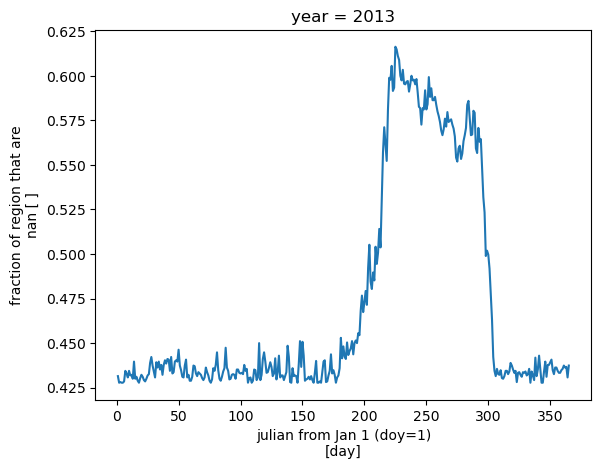

In [116]:
ds_ice.sel(year=2013).nan_frac.plot()